In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin

bb_backend.api.server_adress = 'localhost:8000'
m = bb_utils.meta.BeeMetaInfo()
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

sns.set()

import os

import pickle

from psycopg2 import sql
from itertools import product
from datetime import timedelta, datetime

from scipy import stats
from scipy.stats import norm
import matplotlib.dates as mdates

import h5py
import gc

from tqdm import tqdm_notebook
from skimage.filters import threshold_minimum, threshold_mean
from numba import njit, prange
import dask.distributed
from distributed.security import Security

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [83]:
datetime_start = datetime(2016, 8, 20)
datetime_end = datetime_start + timedelta(hours=1)

In [84]:
with psycopg2.connect(connect_str) as conn:
    query = """SELECT * FROM bb_detections
               WHERE timestamp >= %s AND
                     timestamp < %s AND
                     bee_id_confidence >= %s
               ;"""
    df = pd.read_sql_query(
        query, conn, 
        params=(datetime_start, datetime_end, .9),
        coerce_float=False)

In [85]:
print(df.shape)
single_bee_df = df.loc[df['bee_id'] == 2982]
print(single_bee_df.shape)
df.head()

(4799370, 13)
(10891, 13)


,timestamp,frame_id,detection_idx,track_id,x_pos,y_pos,orientation,x_pos_hive,y_pos_hive,orientation_hive,bee_id,bee_id_confidence,cam_id
0,2016-08-20 00:00:00.166239+00:00,11541169285130378359,87,13637758368366257032,2188,2938,2.86014,NaN,NaN,NaN,2982,1.0,0
1,2016-08-20 00:00:00.499187+00:00,17472436415960557835,86,13637758368366257032,2187,2924,3.00459,NaN,NaN,NaN,2982,1.0,0
2,2016-08-20 00:00:00.831262+00:00,15492161573101461103,87,13637758368366257032,2200,2925,-3.07652,NaN,NaN,NaN,2982,1.0,0
3,2016-08-20 00:00:01.164647+00:00,11862160282083105482,86,13637758368366257032,2225,2937,2.78017,NaN,NaN,NaN,2982,1.0,0
4,2016-08-20 00:00:01.495618+00:00,16552691300949596119,86,13637758368366257032,2237,2950,2.50042,NaN,NaN,NaN,2982,1.0,0


In [86]:
def rolling_average(series):
    return series.rolling(100, center=True, min_periods=1, win_type='gaussian').mean(std=2.5)

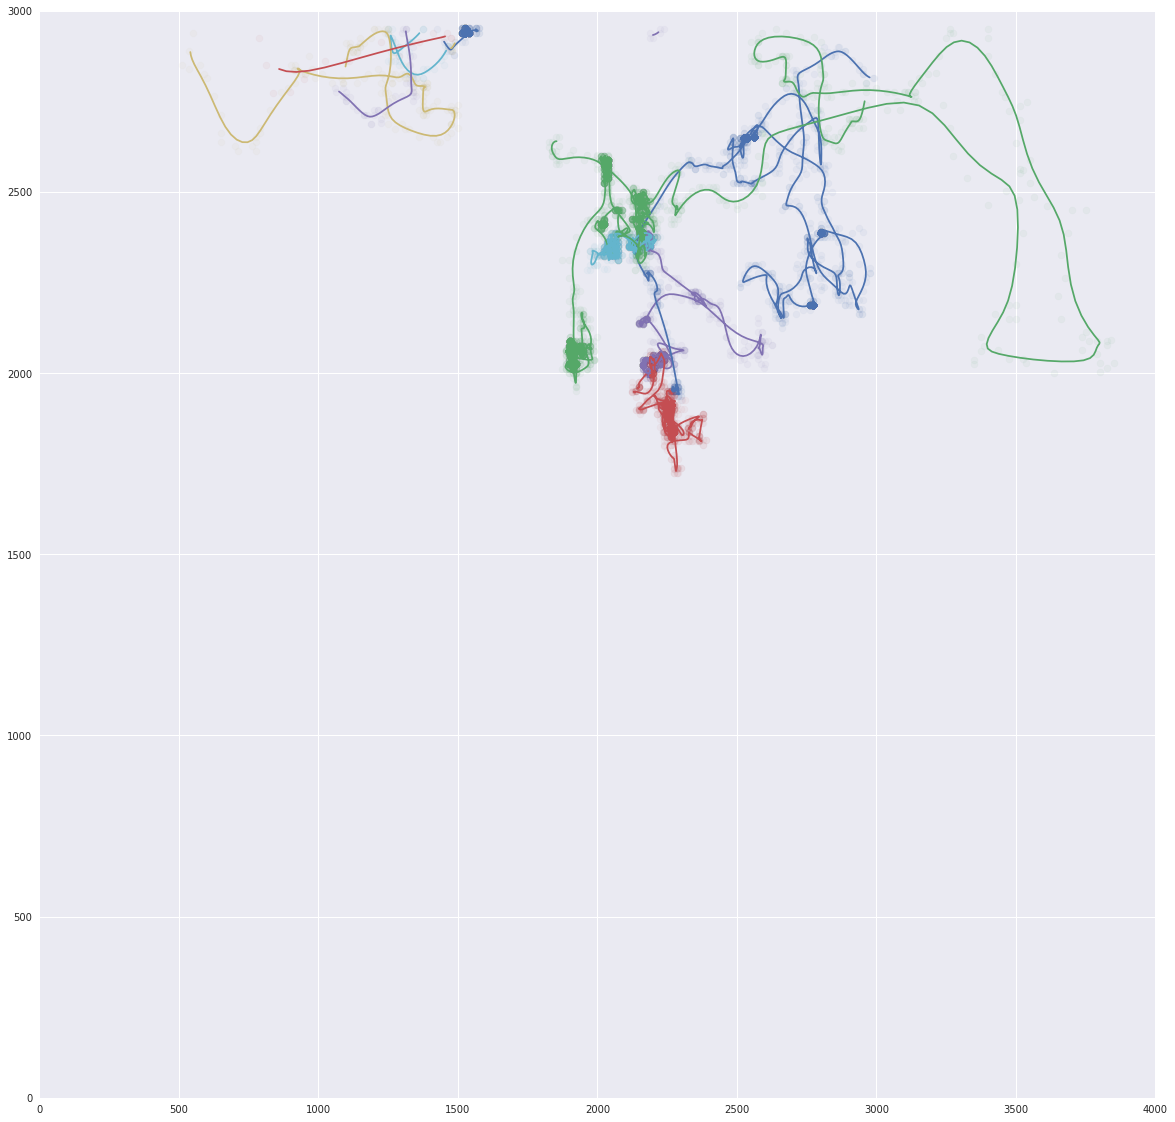

In [88]:
plt.axis([0, 4000, 0, 3000])

# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
s = 0.1
fig_size[0] = 20
fig_size[1] = 20

plt.rcParams["figure.figsize"] = fig_size
for idx, track in single_bee_df.groupby('track_id'):
    plt.scatter(track.x_pos, track.y_pos, alpha=.05)
    plt.plot(rolling_average(track.x_pos), rolling_average(track.y_pos)) 
    plt.plot()
#     break

In [ ]:
i = 0
for idx, track in df.groupby('track_id'):
    plt.scatter(track.x_pos, track.y_pos, alpha=.05)
    plt.plot(rolling_average(track.x_pos), rolling_average(track.y_pos))
    i = i + 1
    if i == 10:
        break

In [19]:
plotters = []

for i in range(len(track)):
    plotters.append(
        FramePlotter(frame_id=int(track.frame_id.iloc[i]), 
                     xs=[int(track.x_pos.iloc[i])], 
                     ys=[int(track.y_pos.iloc[i])],
                     sizes=[25],
                     title=str(track.timestamp.iloc[i]),
                     labels=[int(track.bee_id.iloc[i])], 
                     scale=.5, 
                     colors=["r"]))

In [ ]:
video_plotter = VideoPlotter(frames=plotters, track_labels=True)

video_plotter.get_video(display_in_notebook=True)